In [1]:
# calculate inception score in numpy
from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp
from math import floor
from numpy import std
import glob
from imageio import imread

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.random import shuffle
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
def load_images(paths):
    files = glob.glob(paths)
    images = []
    for i in tqdm(range(len(files))):
        image = imread(files[i])

        # convert integer to floating point values
        # because we need to interpolate
        image = image.astype('float32')
        images.append(image)
    print('load ', paths)

    images = np.array(images)
    if images.shape[-1] == 4:
        images = images[:, :, :, :3]
    return images

cgan_images = load_images('cgan_2/*.png')
acgan_images = load_images('acgan/*.png')
wgangpacgan_images = load_images('wgan_gp-acgan/*.jpg')
wgangpacgan_tf2_images = load_images('wgan_gp-acgan-tf2/*.png')

  0%|          | 0/28 [00:00<?, ?it/s]

load  cgan_2/*.png
load  acgan/*.png


 40%|███▉      | 119/300 [00:00<00:00, 1185.06it/s]

load  wgan_gp-acgan/*.jpg


100%|██████████| 300/300 [00:00<00:00, 1380.83it/s]

load  wgan_gp-acgan-tf2/*.png


In [3]:
from skimage.transform import resize


# need to first make it the right size
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


In [4]:

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

In [5]:
# create a small subset of the image sets
indices = np.random.choice(cgan_images.shape[0], 10, replace=False)
cgan_small = cgan_images[indices]

indices = np.random.choice(acgan_images.shape[0], 10, replace=False)
acgan_small = acgan_images[indices]

indices = np.random.choice(wgangpacgan_images.shape[0], 10, replace=False)
wgangpacgan_small = wgangpacgan_images[indices]

indices = np.random.choice(wgangpacgan_tf2_images.shape[0], 10, replace=False)
wgangpacgan_tf2_small = wgangpacgan_tf2_images[indices]

Initial cgan (10, 220, 220, 3)
Initial acgan (10, 480, 640, 3)
Initial wgan_gp-acgan-tf1 (10, 651, 651, 3)
Initial wgan_gp-acgan-tf2 (10, 64, 64, 3)
Scaled (10, 299, 299, 3)


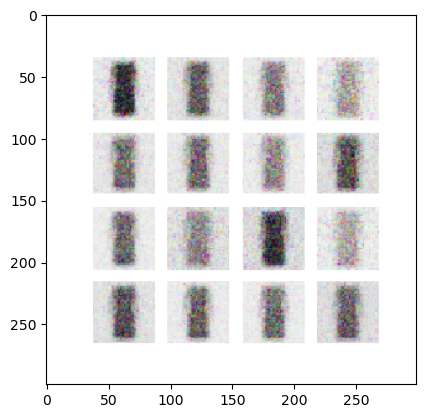

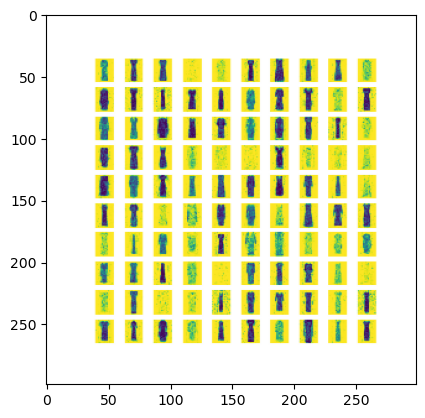

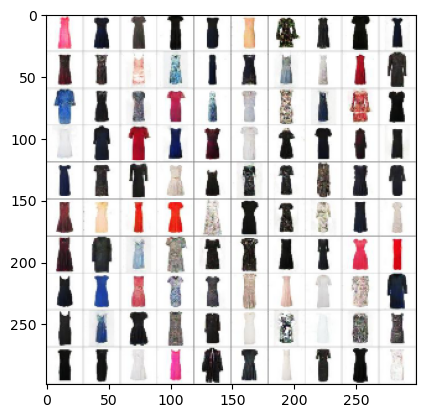

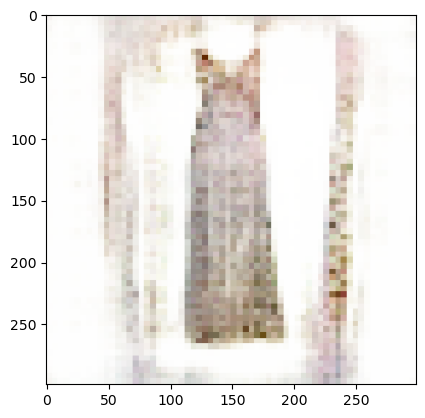

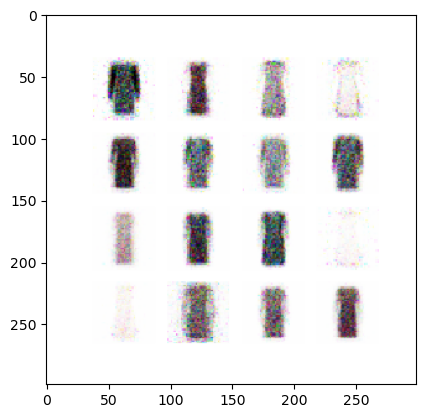

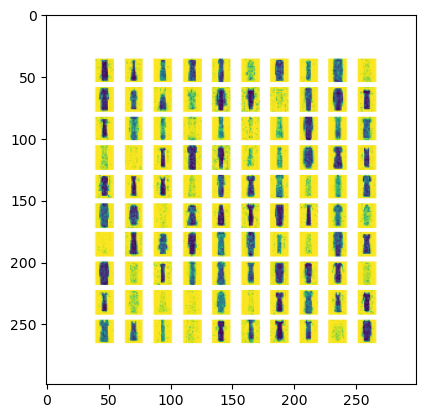

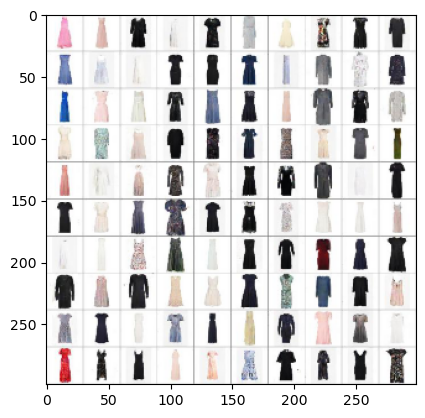

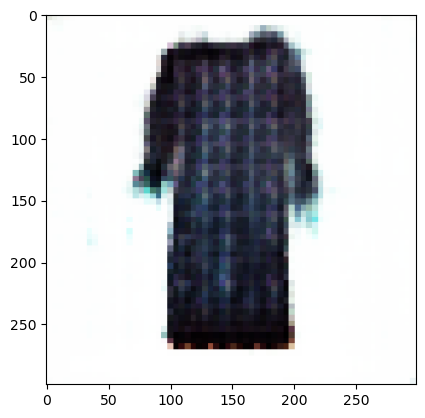

In [6]:
# proprocess the input data -- first we need
# to convert to 299,299,3

# print('Initial', x_train_5_small.shape, x_train_7_small.shape)
print('Initial cgan', cgan_small.shape)
print('Initial acgan', acgan_small.shape)
print('Initial wgan_gp-acgan-tf1', wgangpacgan_small.shape)
print('Initial wgan_gp-acgan-tf2', wgangpacgan_tf2_small.shape)


# resize images

cgan_small = scale_images(cgan_small, (299, 299, 3))
acgan_small = scale_images(acgan_small, (299, 299, 3))
wgangpacgan_small = scale_images(wgangpacgan_small, (299, 299, 3))
wgangpacgan_tf2_small = scale_images(wgangpacgan_tf2_small, (299, 299, 3))

print('Scaled', cgan_small.shape)

for i in range(1, 3):

    plt.imshow(cgan_small[i].astype(int))
    plt.show()

    plt.imshow(acgan_small[i].astype(int))
    plt.show()

    plt.imshow(wgangpacgan_small[i].astype(int))
    plt.show()

    plt.imshow(wgangpacgan_tf2_small[i].astype(int))
    plt.show()

In [7]:
# now we will pre-process for the inception3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# pre-process images

cgan_small = preprocess_input(cgan_small)
acgan_small = preprocess_input(acgan_small)

# calculate frechet inception distance
def calculate_fid(model, img1, img2):
    act1 = model.predict(img1)
    act2 = model.predict(img2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [8]:
# calculate fid

fid = calculate_fid(model, cgan_small, acgan_small)
print('FID cgan vs acgan: %.3f' % fid)

fid = calculate_fid(model, cgan_small, wgangpacgan_small)
print('FID cgan vs wgan_gp-acgan-tf1: %.3f' % fid)

fid = calculate_fid(model, cgan_small, wgangpacgan_tf2_small)
print('FID cgan vs wgan_gp-acgan-tf2: %.3f' % fid)

fid = calculate_fid(model, wgangpacgan_small, wgangpacgan_tf2_small)
print('FID  wgan_gp-acgan-tf1 vs wgan_gp-acgan-tf2: %.3f' % fid)

FID cgan vs acgan: 328.241
FID cgan vs wgan_gp-acgan-tf1: 1105043.850
FID cgan vs wgan_gp-acgan-tf2: 1428400.836
FID  wgan_gp-acgan-tf1 vs wgan_gp-acgan-tf2: 672765.093


In [9]:
# load the full model with the head in intact
# prepare the inception v3 model
full_model = InceptionV3(include_top=True, pooling='avg', input_shape=(299, 299, 3))


In [10]:


# calculate the inception score for p(y|x)
def calculate_inception_score(p_yx, eps=1E-16):
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # kl divergence for each image
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    # undo the logs
    is_score = exp(avg_kl_d)
    return is_score






# assumes images have the shape 299x299x3, pixels in [0,255]
# assume the data has been scaled and pre-processed
def calculate_inception_score(images, n_split=5, eps=1E-16):
    # load inception v3 model
    model = InceptionV3()
    # predict class probabilities for images
    yhat = model.predict(images)
    # enumerate splits of images/predictions
    scores = list()
    # calculate the score in batches
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve p(y|x) these are [0, 0.5, 0, 0.5], etc.
        ix_start, ix_end = i * n_part, i * n_part + n_part
        p_yx = yhat[ix_start:ix_end]
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std


In [11]:
# calculate the inception score

iscore = calculate_inception_score(cgan_small)
print('IS cgan', iscore)

iscore = calculate_inception_score(acgan_small)
print('IS acgan', iscore)

iscore = calculate_inception_score(wgangpacgan_small)
print('IS wgan_gp-acgan-tf1', iscore)

iscore = calculate_inception_score(wgangpacgan_tf2_small)
print('IS wgan_gp-acgan-tf2', iscore)

IS cgan (1.1441628, 0.16348311)
IS acgan (1.0378326, 0.043620586)
IS wgan_gp-acgan-tf1 (1.399486, 0.48926845)
IS wgan_gp-acgan-tf2 (1.8006108, 0.39877847)
